# ABS Inflation model

Aim: to forecasr the next trimmed mean (TM) print based on ...
- upstream inflation PPI
- prevaiing cost pressures WPI
- the Phillips curve (inflation and unemployment have an inverse relationship) UER)
- previous quarter TM, as the series is autocorrelated. 

## Python set-up

In [1]:
# system imports
from pathlib import Path
from typing import Sequence, cast
from math import isfinite

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm 


In [2]:
# local imports
from abs_data_capture import (
    AbsLandingPage,
    AbsMultiSeries,
    AbsSelectInput,
    AbsSelectionDict,
    get_multi_series,
)
from plotting import line_plot, finalise_plot, set_chart_dir, clear_chart_dir

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/Inflation-Model/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# Uaeful markers
QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}


# display charts in this notebook
SHOW = True


## Data capture

 ### Identify the data we want to use

In [4]:
q_wanted: AbsSelectionDict = {
    "Qrtly CPI Trimmed Mean": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="consumer-price-index-australia",
        ),
        table="8",
        orig_sa="SA",
        search1="Percentage Change from Previous Period",
        search2="Trimmed Mean ;  Australia",
        abbr="TM",
        calc_growth=False,
    ),
    "Producer Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="producer-price-indexes-australia",
        ),
        table="1",
        orig_sa="Orig",
        search1="Percentage change from previous quarter",
        search2="Final ;  Total ",
        abbr="PPI",
        calc_growth=False,
    ),
    "Wage Price Index": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="economy",
            parent_topic="price-indexes-and-inflation",
            topic="wage-price-index-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Percentage Change From Previous Quarter",
        search2="Australia ;  Total hourly rates of pay excluding bonuses ;  Private and Public",
        abbr="WPI",
        calc_growth=False,
    ),
}

m_wanted: AbsSelectionDict = {
    "Unemployment Rate": AbsSelectInput(
        landing_page=AbsLandingPage(
            theme="labour",
            parent_topic="employment-and-unemployment",
            topic="labour-force-australia",
        ),
        table="1",
        orig_sa="SA",
        search1="Unemployment rate ;",
        search2="Persons",
        abbr="UER",
        calc_growth=False,
    ),
}

### Collect and marshall that data

In [5]:
def collect_data(
    q_wanted: AbsSelectionDict, m_wanted: AbsSelectionDict
) -> tuple[pd.DataFrame, pd.Index, pd.Series]:
    """Collect the data for the inflation model."""

    # get the quarterly data ...
    q_dataset = get_multi_series(q_wanted, verbose=False)
    fug = {q_dataset[x].abbr: q_dataset[x].series.copy() for x in q_dataset.keys()}
    fugly = pd.DataFrame(fug)
    next = fugly.index[-1] + 1
    new_index = fugly.index.append(pd.PeriodIndex([next]))
    fugly = fugly.reindex(new_index)

    # get UER into quarterly format
    m_dataset = get_multi_series(m_wanted, verbose=False)
    uer = m_dataset["Unemployment Rate"].series.copy()
    uer = uer[uer.index.month.isin([3, 6, 9, 12])].to_timestamp("M").to_period(freq="Q")
    fugly["UER"] = uer

    # shidt PPI and WPI because they are published after CPI
    for shifter in ("WPI", "PPI"):
        fugly[shifter] = fugly[shifter].shift(1)

    # procide differences
    for col in ("WPI", "PPI", "UER"):
        fugly[f"Δ{col}"] = fugly[col].diff(1)

    # add autoregression
    for ar in (1, 2):
        fugly[f"TM-{ar}"] = fugly["TM"].shift(ar)

    # add a constant
    fugly["const"] = 1.0

    # remove NA rows
    data = fugly.dropna()

    # exogenous and out-of-sample endogenous where known variables    
    exogenous = data.columns.difference(['TM'])
    endogenous = fugly.loc[data.index[-1] + 1]

    return data, exogenous, endogenous

### Pipulate out-of-sample endogenous for a forecast

In [6]:
def populate_endog(
    endog: pd.Series,
    exog: pd.Index,
    uer: float | None = None
) -> pd.Series:
    """Populate endogenous"""

    if isfinite(endog["UER"]):
        "UER is already known"
        return endog

    if uer is not None:
        print("Using an externally specified UER")
        endog["UER"] = uer
        return endog

    uer_series = data_nona["UER"]
    projection = (uer_series.iloc[-1] - uer_series.iloc[-2]) + uer_series.iloc[-1]
    endog["UER"] = projection
    return endog



In [7]:

data_nona, exog, endog = collect_data(q_wanted=q_wanted, m_wanted=m_wanted)
endog = populate_endog(endog, exog, uer=4.0)

Using an externally specified UER


## Build a simple multiple regression model

In [8]:
def run_model(exog: list[str], title: str, endog:pd.Series):

    # Fit the model
    X = data_nona[exog]
    y = data_nona['TM']
    model = sm.OLS(y, X)
    fit = model.fit()
    print(fit.summary())

    # QQ plot
    fig = sm.qqplot(fit.resid, line='s');
    name = title.split(" vs ")[1].rsplit(" ", 1)[0]
    finalise_plot(
        fig.axes[0],
        title=f"QQ Plot: {name}",
        xlabel="Theoretical Quantiles",
        ylabel="Sample Quantiles",
        show=SHOW,
    )

    # can we forecast?
    can_forecast = endog[exog].notna().all()
    if can_forecast:
        Xnew = pd.concat([X.iloc[-1:], pd.DataFrame([endog[exog]], index=[X.index[-1] + 1])])
        ynewpred = fit.predict(Xnew)  # predict out of sample
        ynewpred.iloc[0] = y.iloc[-1]  # start from actual
        quarterly = ynewpred.iloc[1]
        annual = ((((pd.concat([y.iloc[-3:-1], ynewpred]) / 100) + 1).cumprod() - 1) * 100).iloc[-1]
        projection = f"Projection {ynewpred.index[-1]}: A:{annual:.2f}% Q:{quarterly:.2f}%"
    projection = projection if can_forecast else ""

    # plot avtual vs predicted
    m = [f"({x}*{round(y, 3)})" for x, y in fit.params.items()]
    m = "ypred = " + " + ".join(m)
    ypred = fit.predict(X)
    model_frame = pd.DataFrame({'Actual': y, 'Within sample predicted': ypred})
    if can_forecast:
        model_frame = model_frame.reindex(model_frame.index.union(ynewpred.index))
        model_frame['Out of sample forecast'] = ynewpred
    line_plot(
        model_frame, 
        title=title,
        ylabel="Inflation % per quarter",
        color=("cornflowerblue", "darkorange", "darkred"),
        width=(1.5, 2, 3),
        **QUARTERLY_RANGE,
        lfooter=m,
        rfooter=projection,
        y0=True,
        show=SHOW,
    )

In [9]:
# Everything - quite a number of these coefficients not significantly different from zero
# Uktimately not a useful model
#title = "Trimmed Mean Inflation vs Model Predicted"
#run_model(exog, title, endog)

                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     53.72
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.81e-20
Time:                        22:30:42   Log-Likelihood:                 26.719
No. Observations:                 100   AIC:                            -45.44
Df Residuals:                      96   BIC:                            -35.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TM-1           0.4815      0.100      4.824      0.0

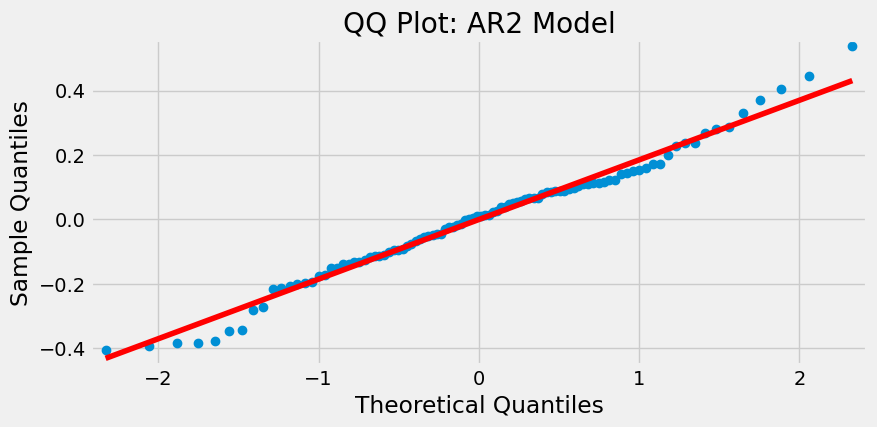

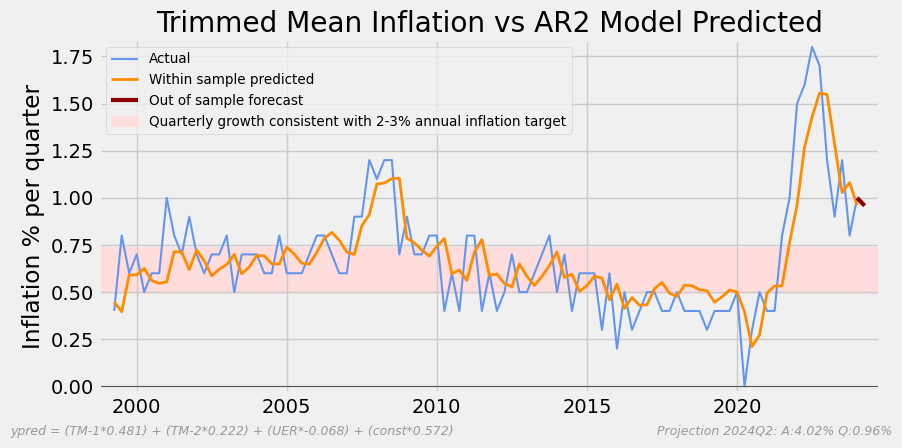

In [10]:
# REMOVE cooefficients that are not significantly different from zero
exog = ['TM-1', 'TM-2', 'UER', 'const']
title = "Trimmed Mean Inflation vs AR2 Model Predicted"
run_model(exog, title, endog)

                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     74.72
Date:                Fri, 03 May 2024   Prob (F-statistic):           2.29e-20
Time:                        22:30:43   Log-Likelihood:                 24.070
No. Observations:                 100   AIC:                            -42.14
Df Residuals:                      97   BIC:                            -34.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TM-1           0.6324      0.076      8.273      0.0

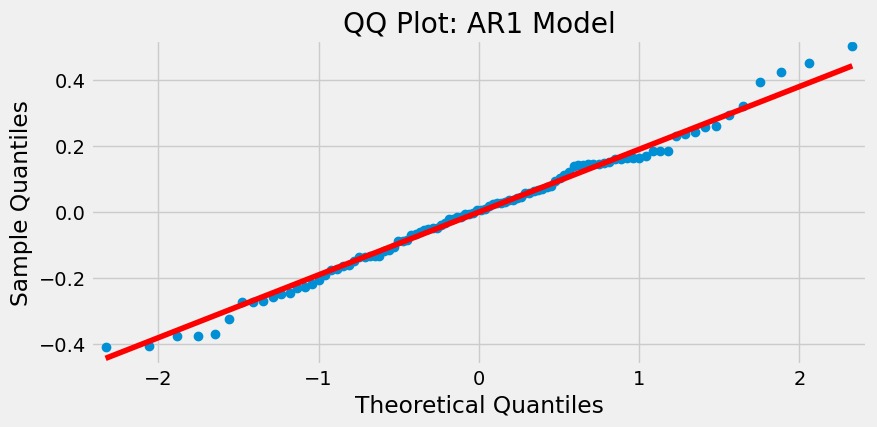

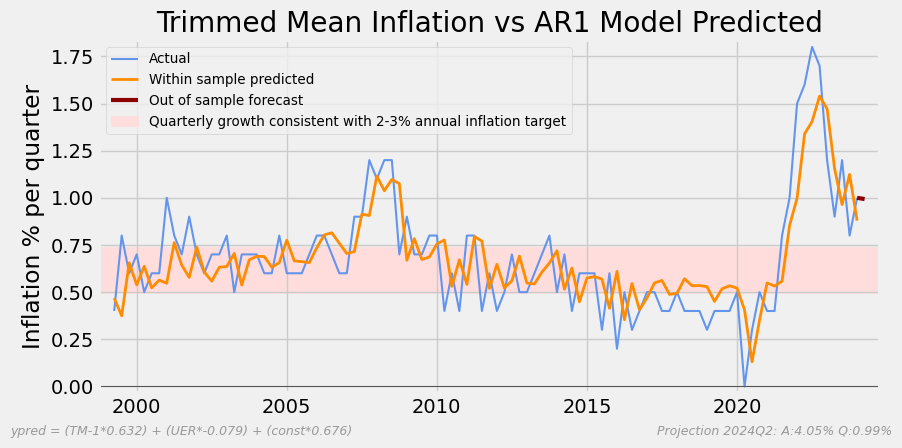

In [11]:
exog = ['TM-1', 'UER', 'const']
title = "Trimmed Mean Inflation vs AR1 Model Predicted"
run_model(exog, title, endog)

## Finished

In [12]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri May 03 2024 22:30:43

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

numpy      : 1.26.4
pandas     : 2.2.2
matplotlib : 3.8.4
statsmodels: 0.14.1

Watermark: 2.4.3



In [13]:
print("Finished")

Finished
